<a href="https://colab.research.google.com/github/samaneh-m/TU-simulation-base-inference/blob/main/forward_backward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install "bayesflow>=2.0"
!pip install tensorflow hmmlearn  # Add hmmlearn for HMM inference

In [16]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import bayesflow as bf
import numpy as np
import tensorflow as tf
from hmmlearn import hmm

from tensorflow.keras.utils import to_categorical

# Amino‑acid mapping
amino_acids = ['A','R','N','D','C','E','Q','G','H','I',
               'L','K','M','F','P','S','T','W','Y','V']
aa_to_int = {aa:i for i, aa in enumerate(amino_acids)}

class HMMHiddenStateSimulator:
    def __init__(self, seq_len=50):
        self.seq_len = seq_len
        self.transmat = np.array([[0.90, 0.10],[0.05, 0.95]])
        self.startprob = np.array([0.0, 1.0])
        emissions = {
            'alpha': np.array([12,6,3,5,1,9,5,4,2,7,12,6,3,4,2,5,4,1,3,6]) / 100,
            'other': np.array([6,5,5,6,2,5,3,9,3,5,8,6,2,4,6,7,6,1,4,7]) / 100
        }
        self.emissionprob = np.stack([emissions['alpha'], emissions['other']])
        # ✅ Use categorical HMM for integer observations
        self.model = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="")
        self.model.startprob_ = self.startprob
        self.model.transmat_ = self.transmat
        self.model.emissionprob_ = self.emissionprob

    def sample(self, n_sequences=1000):
        X = []
        for _ in range(n_sequences):
            seq, _ = self.model.sample(n_samples=self.seq_len)
            X.append(seq.flatten())
        X_all = np.concatenate(X).reshape(-1, 1)
        post_probs = self.model.predict_proba(X_all)
        theta_post = post_probs[:, 0].reshape(n_sequences, self.seq_len)
        x_obs = np.array(X).reshape(n_sequences, self.seq_len)
        return x_obs, theta_post

# Simulate data & encode
sim = HMMHiddenStateSimulator(seq_len=50)
x_train, theta_train = sim.sample(n_sequences=1000)
x_train_onehot = to_categorical(x_train, num_classes=20)

class ReplaySimulator:
    def __init__(self, x_data, theta_data):
        self.x = x_data
        self.theta = theta_data
        self.n = theta_data.shape[0]

    def sample(self, batch_size):
        idx = np.random.choice(self.n, size=batch_size, replace=False)
        return {"hidden_states": self.theta[idx], "observations": self.x[idx]}

# BayesFlow setup
N, seq_len, AA = x_train_onehot.shape

summary_net = bf.networks.TimeSeriesNetwork(
    input_shape=(seq_len, AA),
    summary_variables=["observations"],
    layers=[128, 64],
    rnn_units=64
)

inference_net = bf.networks.CouplingFlow(
    n_parameters=seq_len,
    context_summary=["observations"],
    coupling_layers=6,
    hidden_sizes=[128, 128]
)

simulator = ReplaySimulator(x_train_onehot, theta_train)

workflow = bf.BasicWorkflow(
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=["hidden_states"],
    summary_variables=["observations"],
    simulator=simulator
)

# ✅ Train with soft posteriors instead of hard labels
history = workflow.fit_online(
    epochs=15,
    batch_size=64,
    num_batches_per_epoch=200
)


INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 18.6798
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: -22.9299
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: -28.6909
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: -33.5615
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: -38.2995
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: -42.8008
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: -46.7599
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: -50.0118
Epoch 9/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: -52.6823
Epoch 10/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: -55.3957
Epoch 11/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: -57.5497
Epoch 12/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: -59.5766
Epoch 13/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: -60.8865
Epoch 14/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: -61.8365
Ep

In [3]:
# ✅ Train with soft posteriors instead of hard labels
#history2 = workflow.fit_online(
 #   epochs=20,
#    batch_size=64,
 #   num_batches_per_epoch=200
#)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# --- Load and Preprocess Real Data ---
df = pd.read_csv("realdata1.csv")  # Load your dataset

# Define amino acids
amino_acids = ['A','R','N','D','C','E','Q','G','H','I',
               'L','K','M','F','P','S','T','W','Y','V']
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Filter invalid sequences and convert to ints
encoded = []
lengths = []
valid_seqs = []
labels = [] if "label" in df.columns else None

for i, row in df.iterrows():
    s = row['seq']
    ints = [aa_to_int.get(aa, -1) for aa in s]
    if any(i < 0 for i in ints):
        print(f"Skipping invalid sequence at index {i}: {s}")
        continue
    encoded.append(ints)
    lengths.append(len(ints))
    valid_seqs.append(s)
    if labels is not None:
        labels.append(row['label'])

# Optional: truncate long sequences
df = df[df['len'] <= 100].reset_index(drop=True)

# Pad and one-hot encode
max_len = max(lengths)
num = len(encoded)
x_onehot = np.zeros((num, max_len, len(amino_acids)), dtype=np.float32)

for i, ints in enumerate(encoded):
    x_onehot[i, :len(ints)] = to_categorical(ints, num_classes=len(amino_acids))

# --- Posterior Sampling in Batches ---
BATCH_SIZE = 128
posterior_means = []

for start in range(0, num, BATCH_SIZE):
    end = start + BATCH_SIZE
    batch_input = x_onehot[start:end]
    posterior = workflow.sample(conditions={"observations": batch_input}, num_samples=100)
    post_mean = np.mean(posterior["hidden_states"], axis=0)
    posterior_means.append(post_mean)

posterior_means = np.concatenate(posterior_means, axis=0)



=== Diagnostic Metrics Summary ===
       hidden_states_0  hidden_states_1  hidden_states_2  hidden_states_3  \
count         3.000000         3.000000         3.000000         3.000000   
mean          0.290043         0.318165         0.344396         0.353611   
std           0.201724         0.292925         0.371482         0.425545   
min           0.091053         0.080263         0.076842         0.060526   
25%           0.187868         0.154577         0.132327         0.109559   
50%           0.284684         0.228892         0.187811         0.158591   
75%           0.389539         0.437116         0.478173         0.500154   
max           0.494393         0.645340         0.768536         0.841716   

       hidden_states_4  hidden_states_5  hidden_states_6  hidden_states_7  \
count         3.000000         3.000000         3.000000         3.000000   
mean          0.358898         0.352470         0.352611         0.350480   
std           0.454545         0.479923

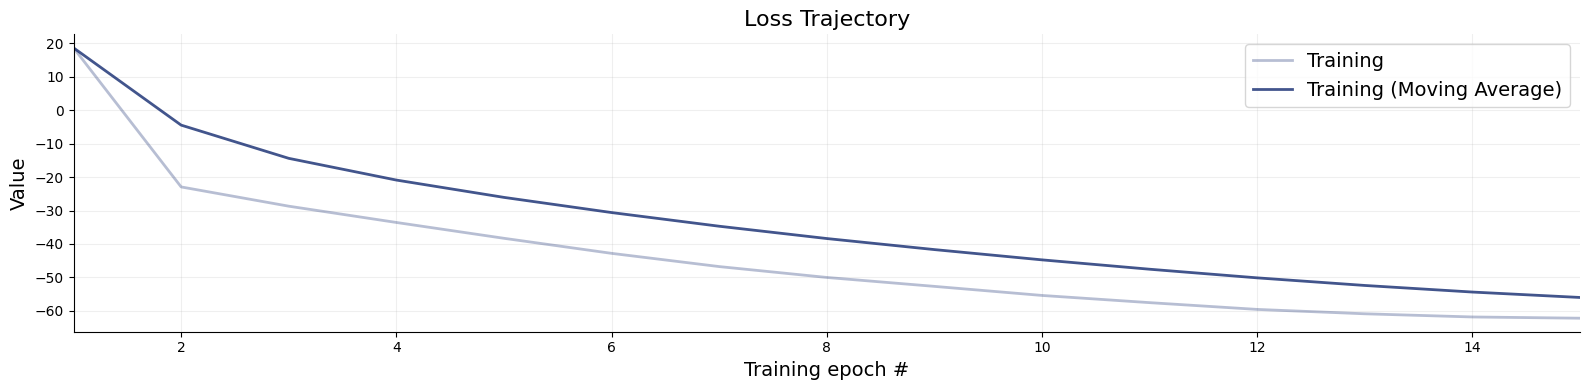

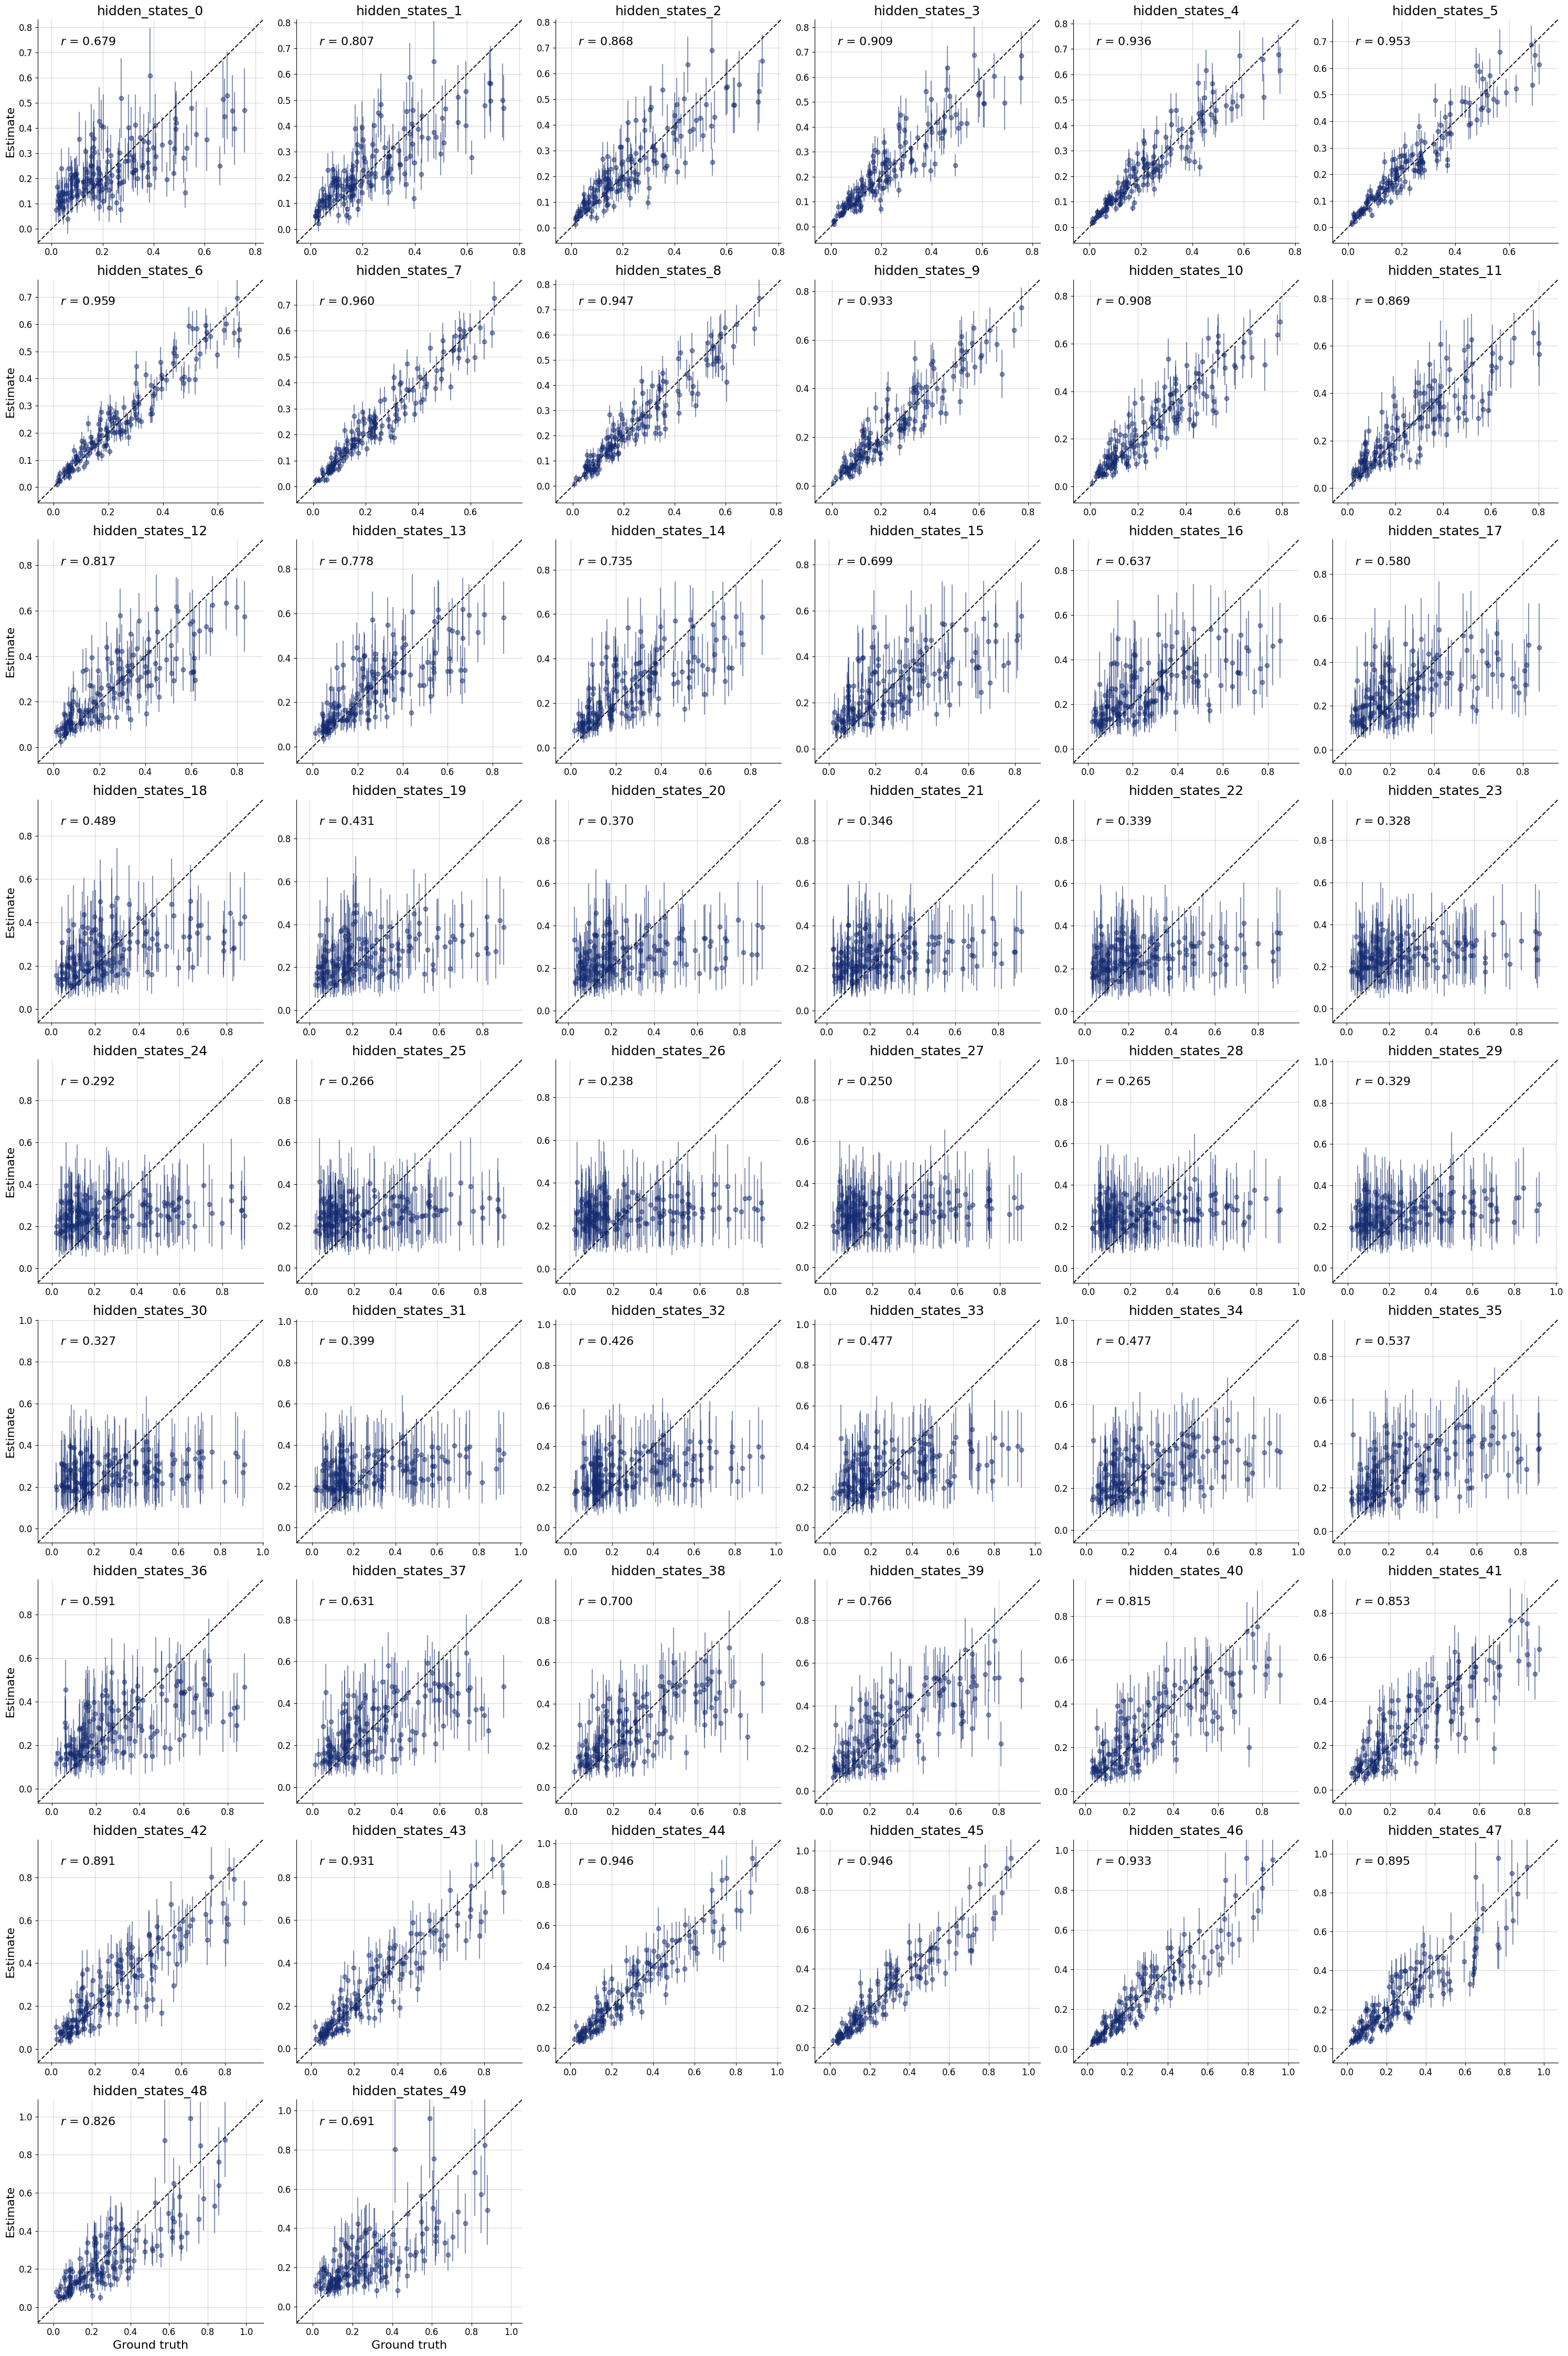

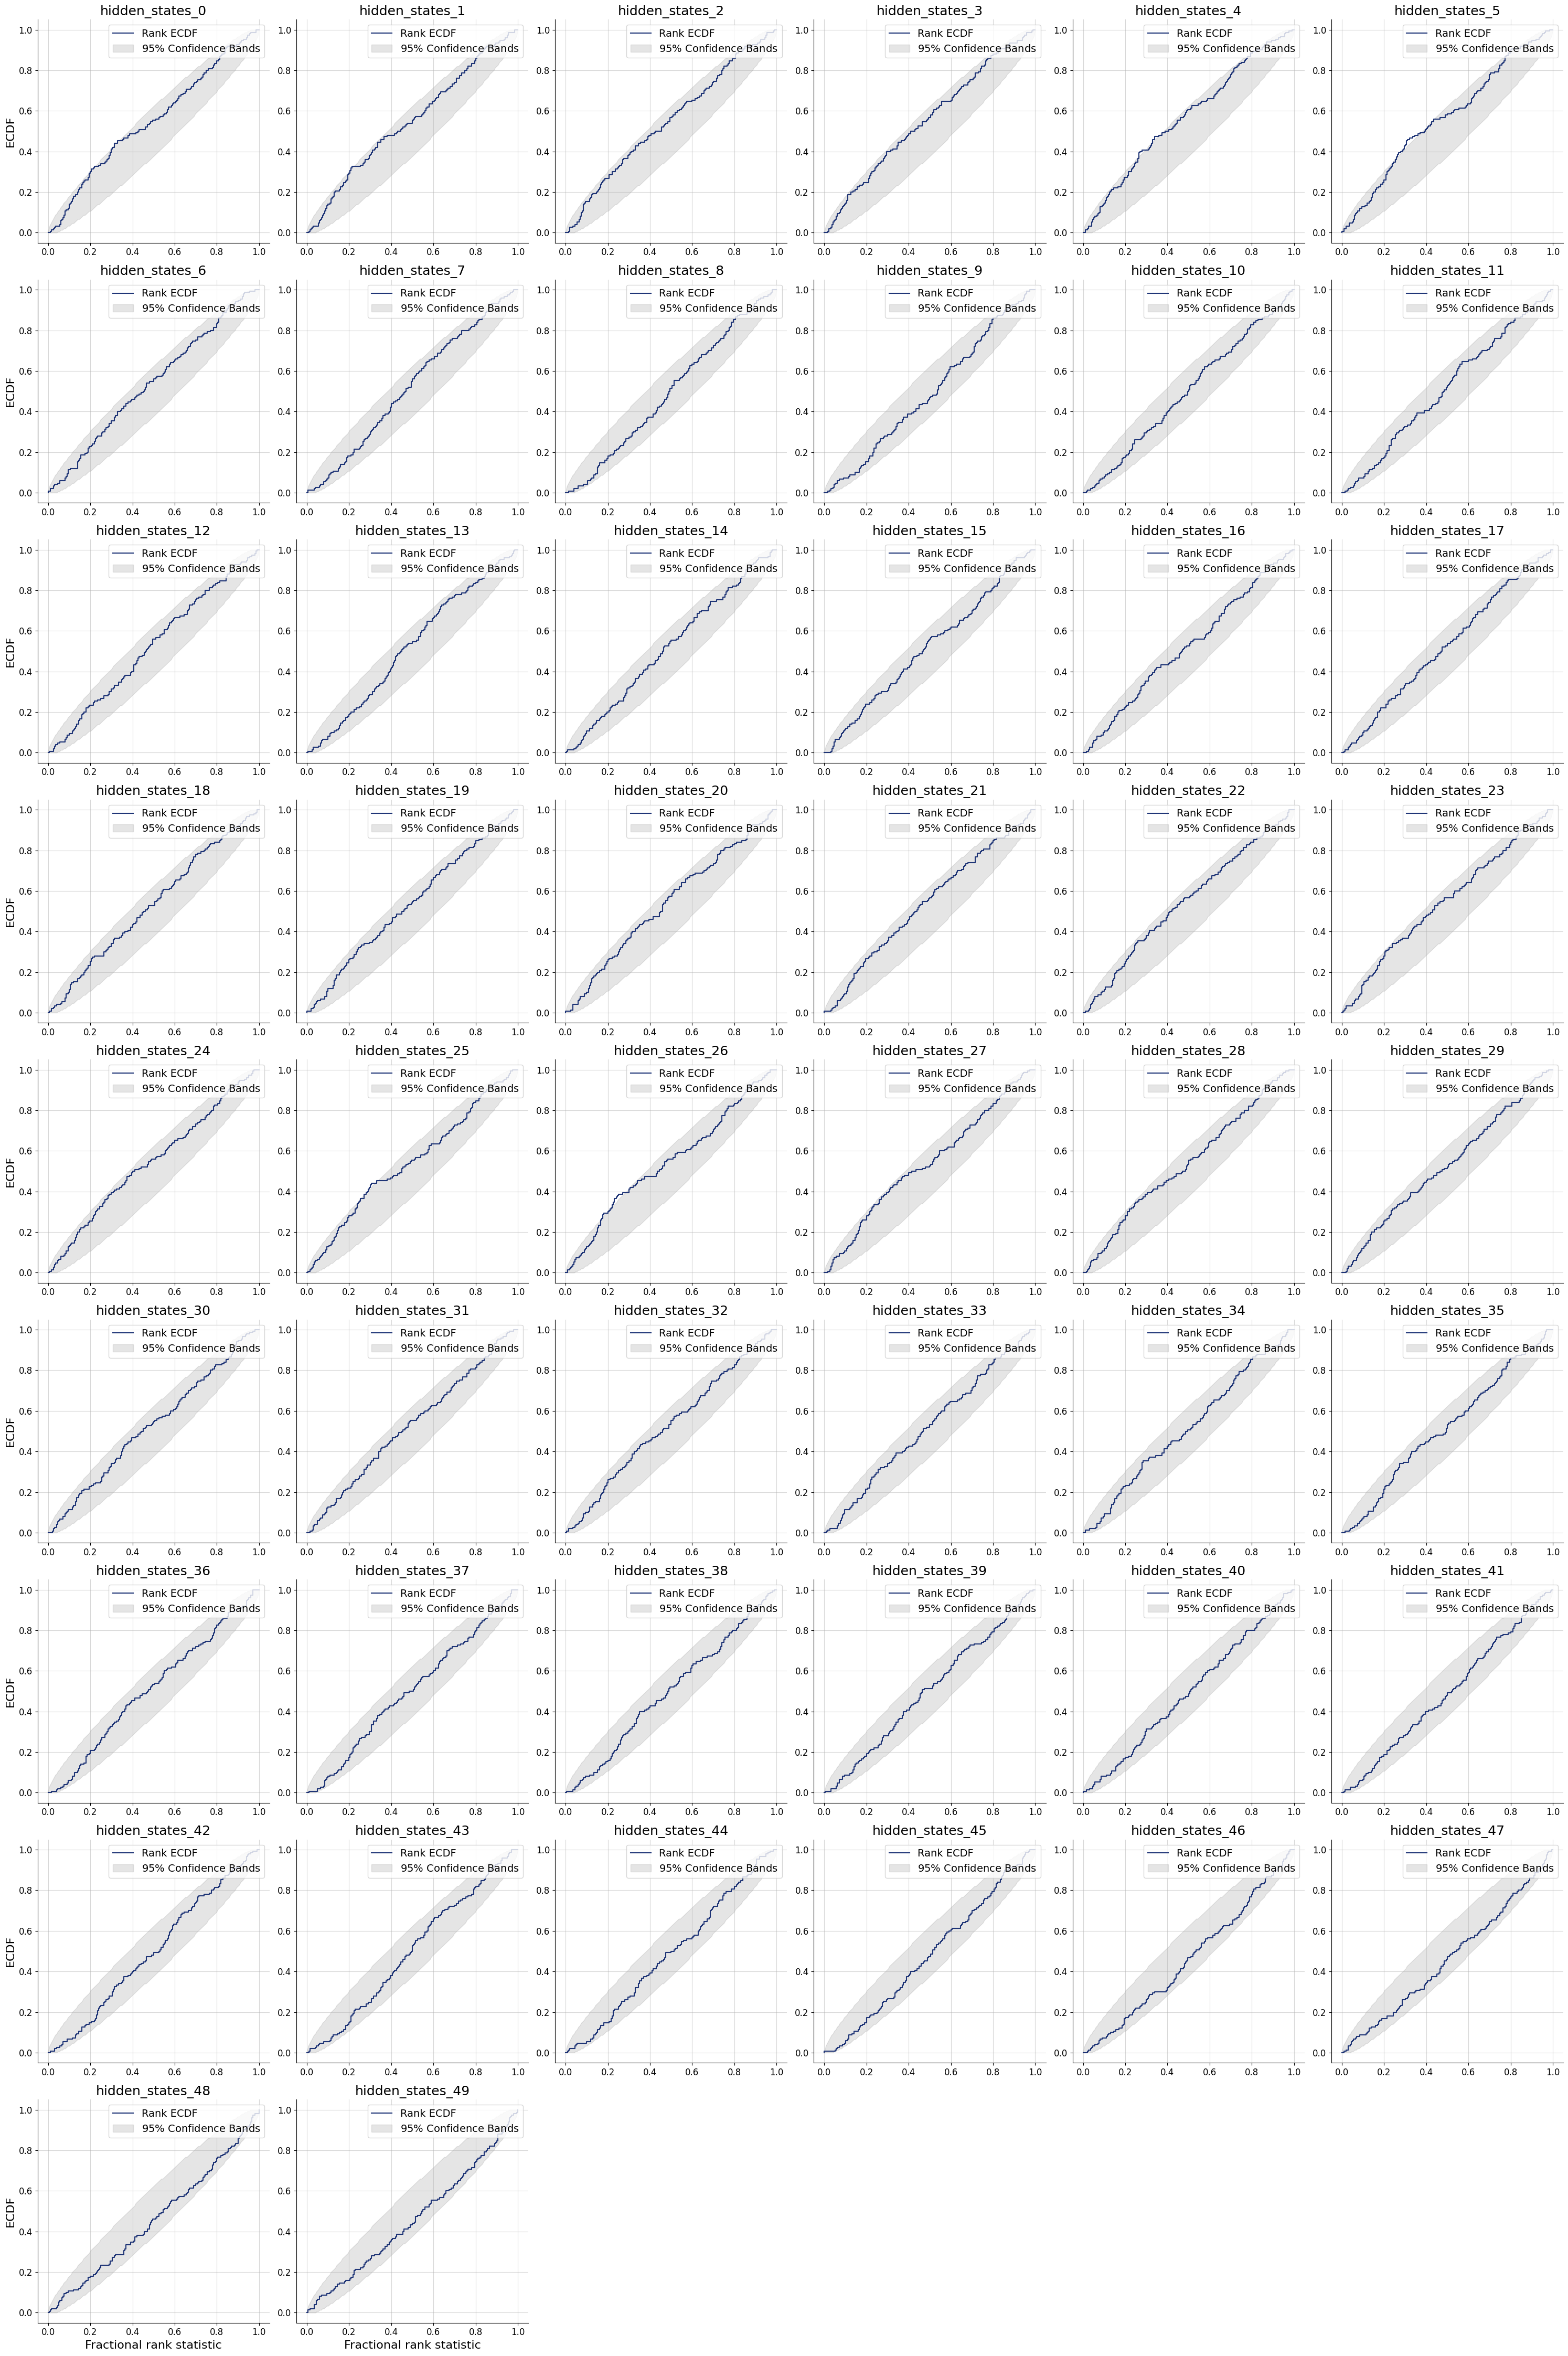

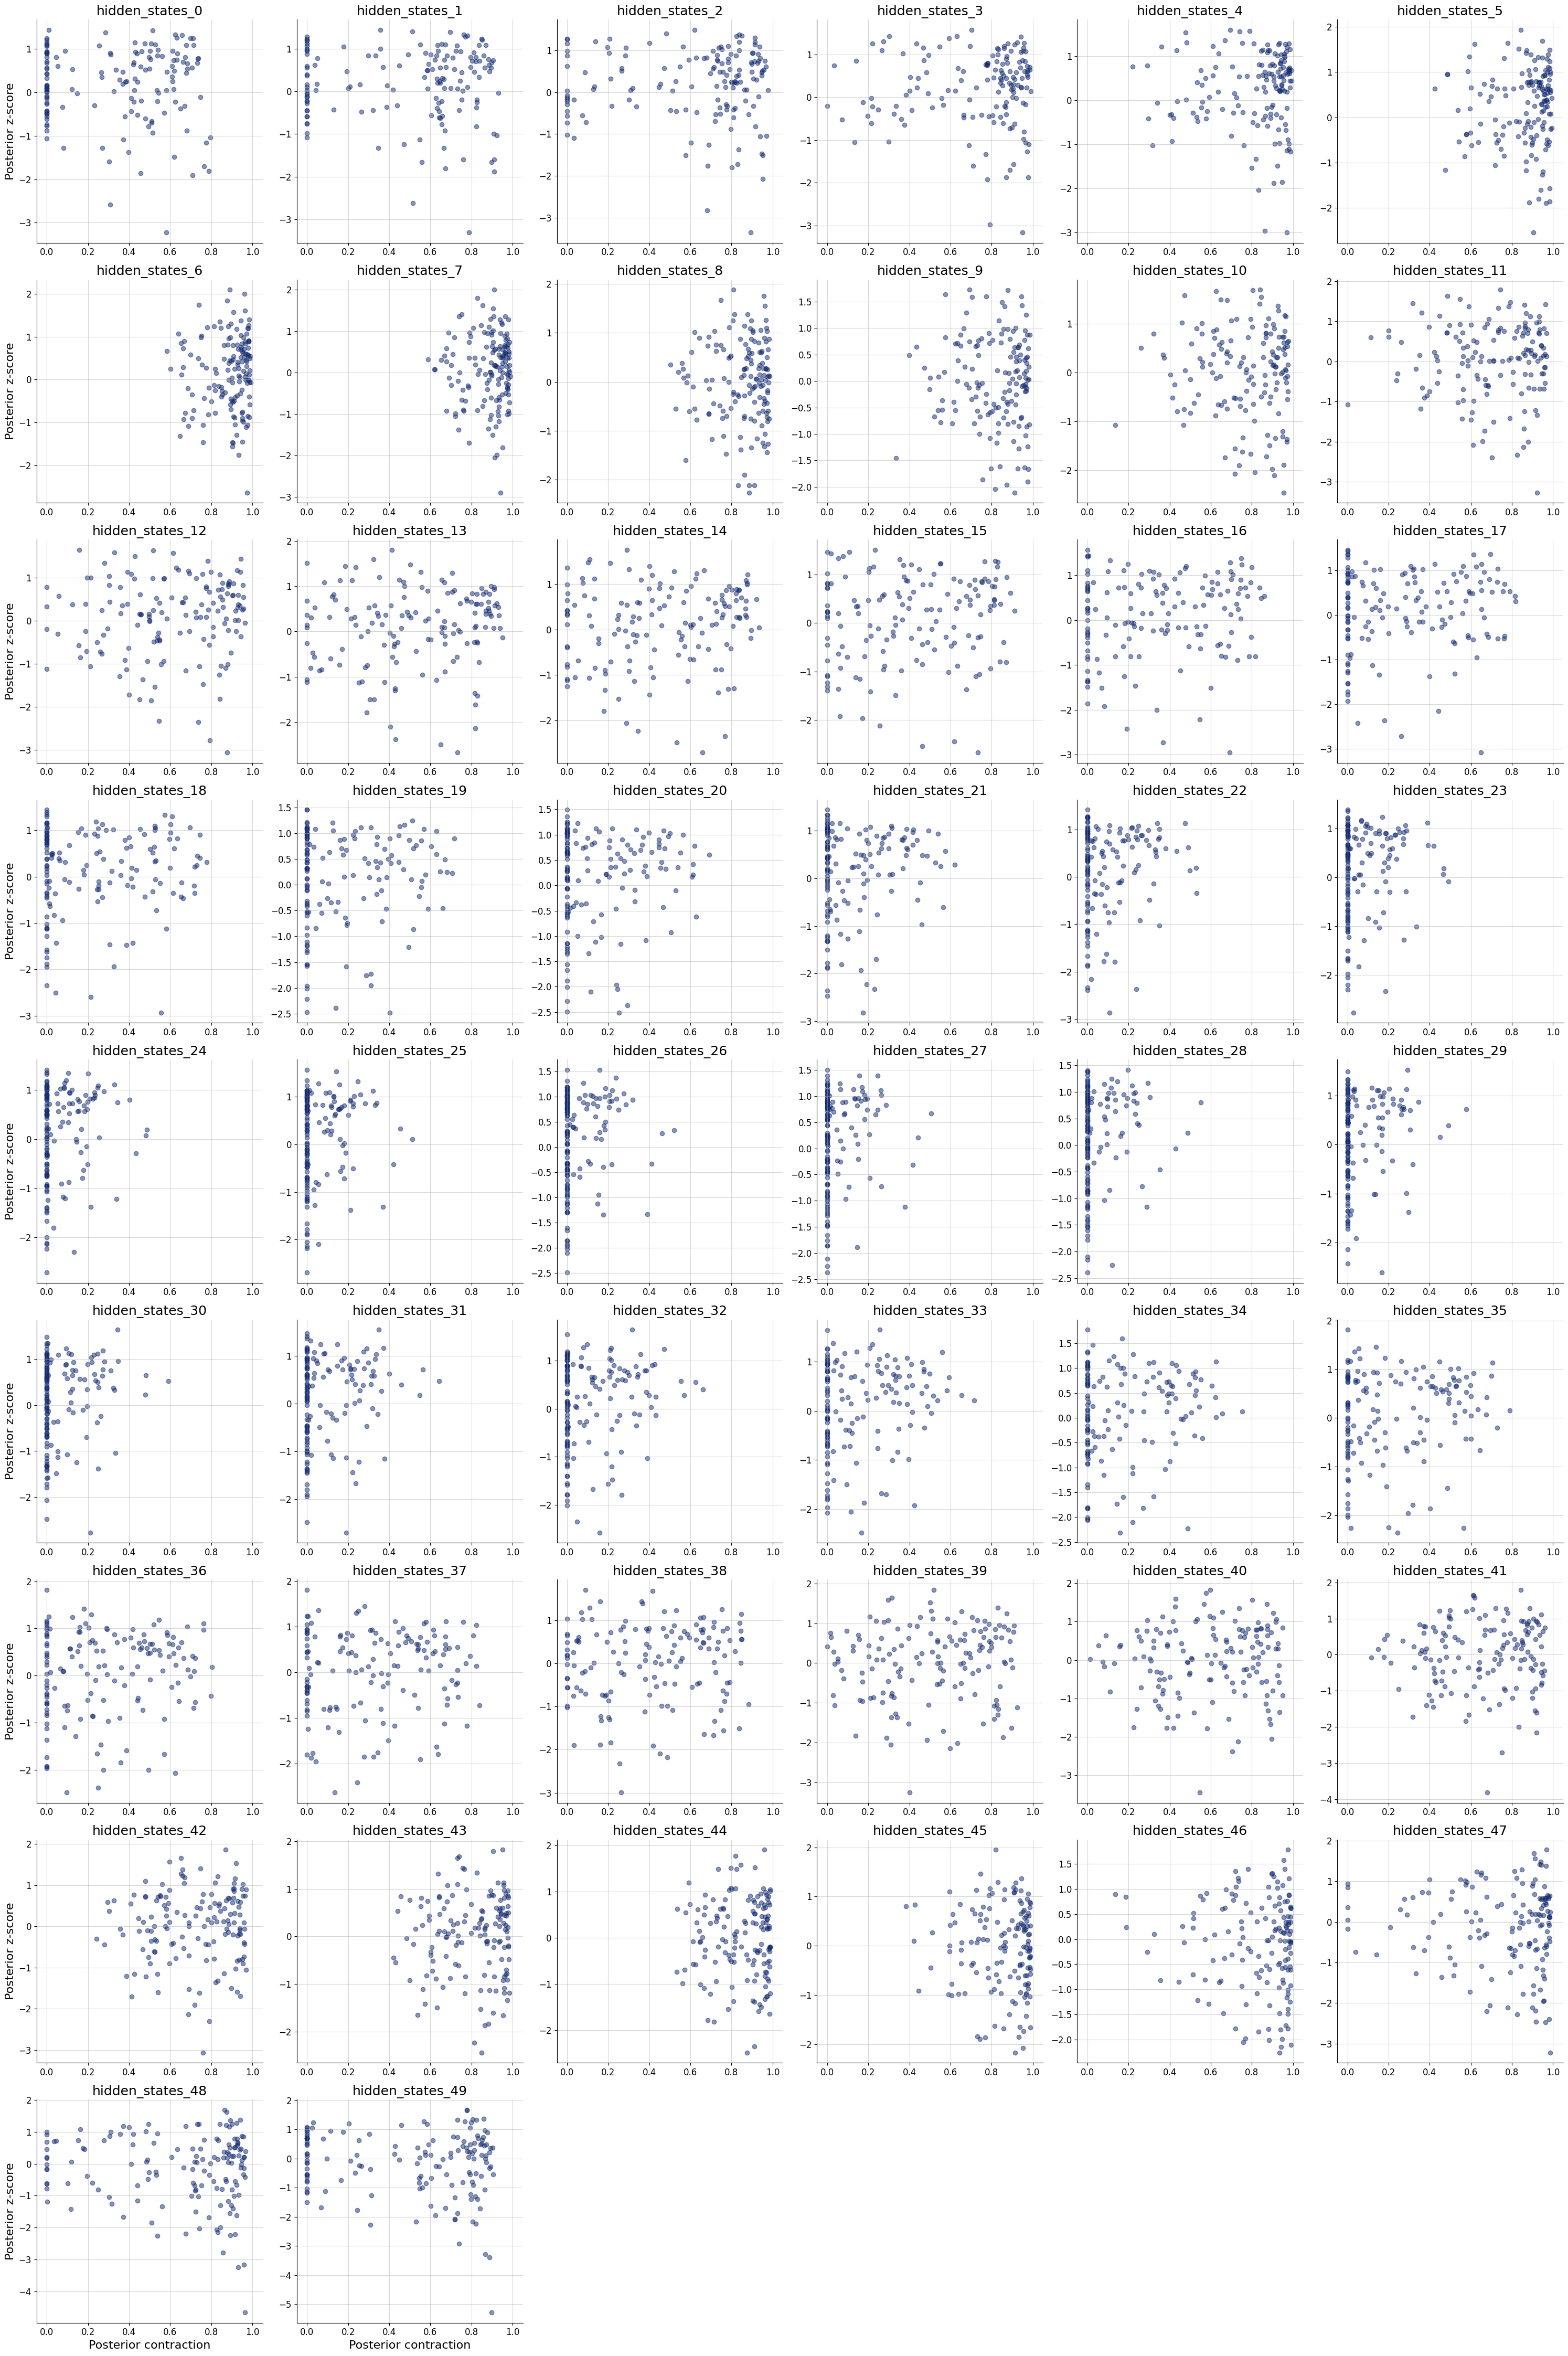

In [19]:
# --- Evaluate model with built-in BayesFlow diagnostics ---

# 1. Plot diagnostics (returns figures)
workflow.plot_diagnostics(test_data=150, num_samples=200)

# 2. Compute numeric diagnostics (returns DataFrame)
df_metrics = workflow.compute_default_diagnostics(
    test_data=150,
    num_samples=200,
    as_data_frame=True
)

print("\n=== Diagnostic Metrics Summary ===")
print(df_metrics.describe())


Sequence 0, length 15:
Posterior mean P(alpha): [0.292 0.298 0.298 0.311 0.315 0.308 0.315 0.318 0.308 0.305 0.319 0.325
 0.312 0.324 0.311]


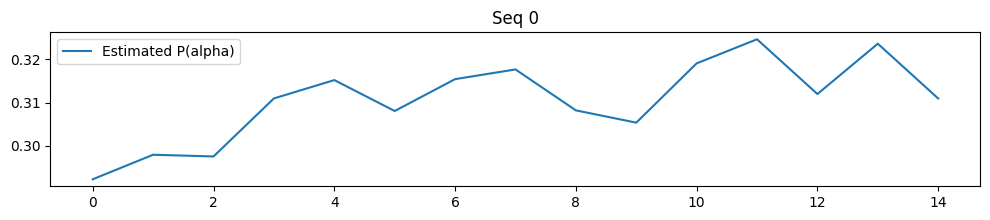


Sequence 1, length 39:
Posterior mean P(alpha): [0.345 0.349 0.342 0.362 0.358 0.349 0.369 0.338 0.326 0.308 0.307 0.313
 0.305 0.314 0.311 0.315 0.32  0.321 0.312 0.312 0.306 0.296 0.288 0.29
 0.297 0.299 0.316 0.323 0.332 0.327 0.345 0.337 0.341 0.338 0.34  0.354
 0.352 0.354 0.364]


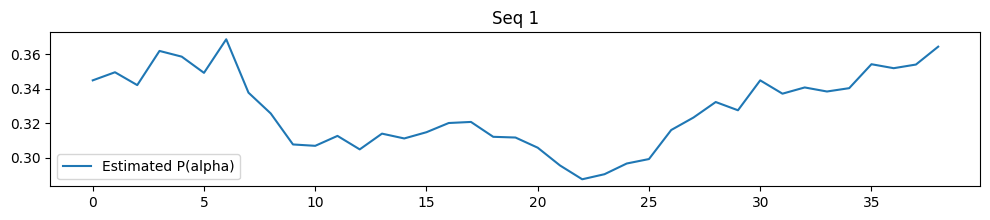


Sequence 2, length 74:
Posterior mean P(alpha): [0.333 0.34  0.356 0.38  0.386 0.372 0.404 0.371 0.363 0.351 0.347 0.34
 0.332 0.34  0.332 0.333 0.326 0.325 0.329 0.333 0.34  0.335 0.328 0.332
 0.321 0.326 0.33  0.327 0.333 0.33  0.339 0.33  0.32  0.311 0.312 0.322
 0.321 0.32  0.324 0.327 0.33  0.326 0.341 0.341 0.347 0.339 0.346 0.341
 0.348 0.319]


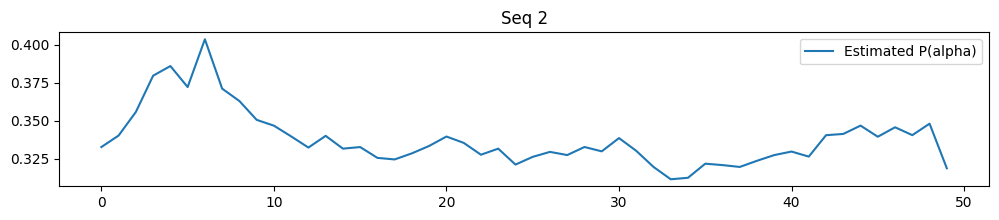


Sequence 3, length 60:
Posterior mean P(alpha): [0.304 0.315 0.319 0.334 0.335 0.33  0.34  0.34  0.33  0.328 0.351 0.362
 0.368 0.382 0.373 0.386 0.385 0.374 0.378 0.381 0.389 0.385 0.377 0.39
 0.377 0.362 0.367 0.361 0.364 0.359 0.367 0.358 0.348 0.345 0.345 0.356
 0.342 0.342 0.355 0.355 0.352 0.343 0.343 0.343 0.339 0.33  0.325 0.321
 0.319 0.296]


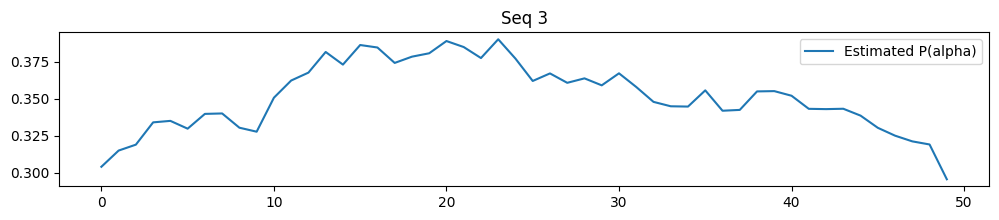


Sequence 4, length 127:
Posterior mean P(alpha): [0.295 0.291 0.291 0.298 0.301 0.298 0.315 0.307 0.298 0.297 0.301 0.3
 0.294 0.314 0.301 0.32  0.323 0.322 0.325 0.329 0.341 0.335 0.334 0.34
 0.329 0.328 0.339 0.344 0.359 0.355 0.368 0.356 0.348 0.339 0.343 0.358
 0.351 0.346 0.354 0.337 0.33  0.318 0.314 0.311 0.31  0.3   0.301 0.323
 0.341 0.333]


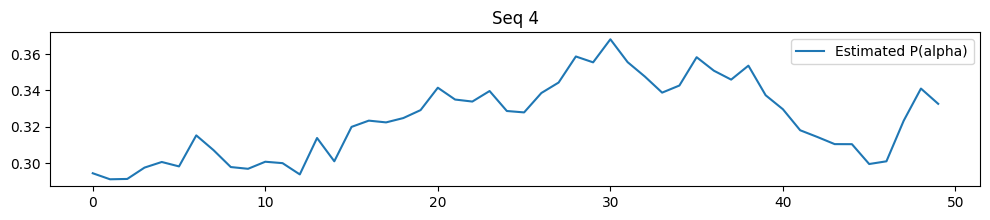


Sequence 5, length 118:
Posterior mean P(alpha): [0.288 0.285 0.3   0.321 0.336 0.329 0.348 0.328 0.32  0.322 0.323 0.319
 0.323 0.342 0.332 0.34  0.338 0.34  0.352 0.354 0.365 0.357 0.344 0.35
 0.339 0.326 0.333 0.322 0.328 0.324 0.336 0.336 0.335 0.339 0.34  0.356
 0.35  0.347 0.344 0.336 0.333 0.325 0.312 0.301 0.293 0.285 0.288 0.291
 0.297 0.282]


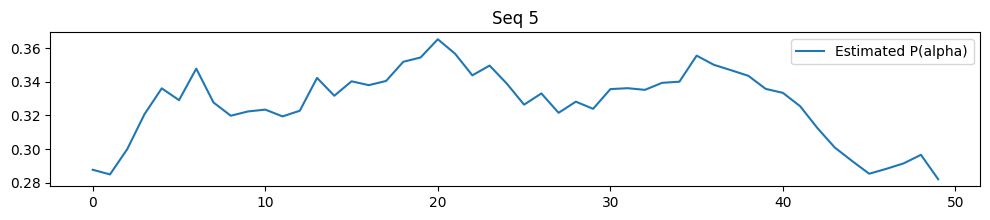


Sequence 6, length 92:
Posterior mean P(alpha): [0.272 0.279 0.279 0.289 0.294 0.286 0.293 0.287 0.28  0.279 0.288 0.3
 0.3   0.32  0.318 0.331 0.33  0.328 0.325 0.327 0.334 0.331 0.33  0.339
 0.329 0.335 0.348 0.353 0.359 0.349 0.357 0.35  0.348 0.345 0.352 0.361
 0.351 0.351 0.361 0.359 0.355 0.351 0.348 0.339 0.338 0.325 0.317 0.315
 0.306 0.283]


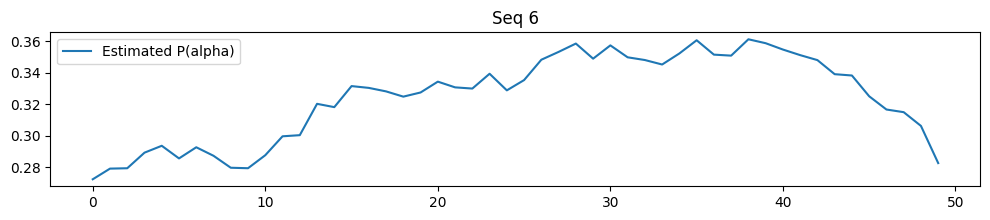


Sequence 7, length 99:
Posterior mean P(alpha): [0.342 0.346 0.333 0.335 0.328 0.33  0.345 0.34  0.324 0.327 0.34  0.351
 0.352 0.372 0.368 0.366 0.354 0.338 0.327 0.323 0.326 0.329 0.331 0.336
 0.337 0.322 0.336 0.327 0.332 0.314 0.319 0.304 0.296 0.288 0.29  0.305
 0.3   0.298 0.297 0.289 0.291 0.287 0.286 0.282 0.284 0.286 0.29  0.283
 0.285 0.269]


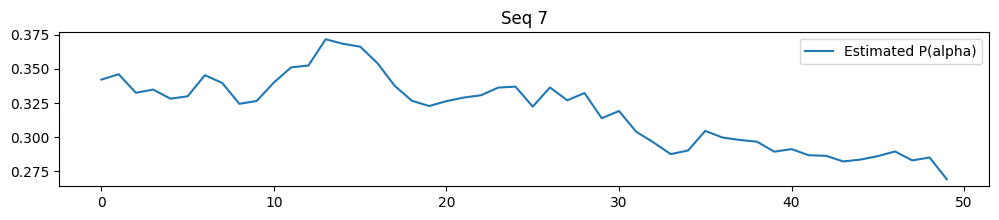


Sequence 8, length 133:
Posterior mean P(alpha): [0.259 0.262 0.27  0.277 0.281 0.286 0.293 0.293 0.284 0.284 0.293 0.305
 0.302 0.315 0.31  0.317 0.316 0.317 0.315 0.315 0.326 0.323 0.318 0.327
 0.321 0.312 0.326 0.323 0.325 0.32  0.33  0.33  0.33  0.334 0.357 0.368
 0.365 0.356 0.351 0.341 0.347 0.346 0.347 0.35  0.349 0.341 0.341 0.334
 0.334 0.316]


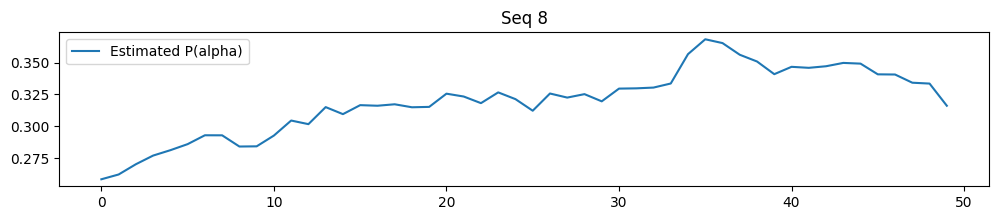


Sequence 9, length 142:
Posterior mean P(alpha): [0.295 0.297 0.31  0.327 0.337 0.341 0.349 0.345 0.342 0.341 0.357 0.357
 0.347 0.366 0.358 0.356 0.349 0.338 0.323 0.312 0.306 0.304 0.298 0.301
 0.301 0.295 0.315 0.317 0.325 0.323 0.336 0.337 0.334 0.334 0.336 0.347
 0.341 0.343 0.348 0.353 0.363 0.359 0.375 0.373 0.393 0.386 0.392 0.396
 0.404 0.385]


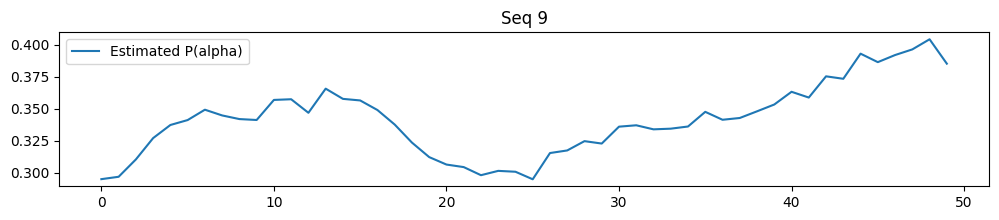


Sequence 10, length 149:
Posterior mean P(alpha): [0.289 0.292 0.303 0.318 0.326 0.324 0.337 0.331 0.336 0.33  0.339 0.341
 0.327 0.336 0.333 0.337 0.338 0.34  0.344 0.347 0.36  0.348 0.335 0.336
 0.325 0.31  0.315 0.307 0.309 0.302 0.316 0.309 0.305 0.309 0.319 0.33
 0.326 0.32  0.326 0.328 0.325 0.332 0.331 0.336 0.342 0.335 0.343 0.339
 0.35  0.323]


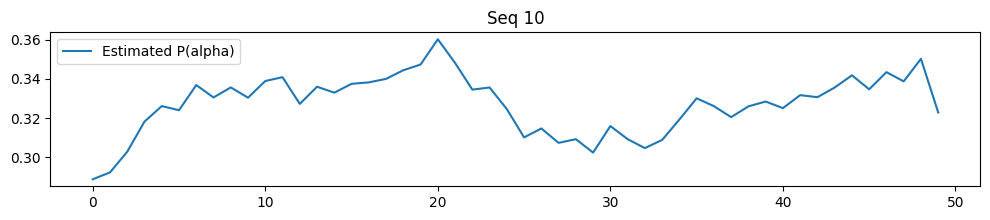


Sequence 11, length 93:
Posterior mean P(alpha): [0.295 0.305 0.309 0.323 0.335 0.334 0.352 0.344 0.34  0.341 0.344 0.339
 0.331 0.346 0.344 0.344 0.34  0.336 0.329 0.335 0.342 0.334 0.32  0.319
 0.316 0.314 0.333 0.337 0.346 0.348 0.356 0.342 0.336 0.333 0.334 0.341
 0.332 0.333 0.345 0.344 0.347 0.328 0.344 0.336 0.347 0.338 0.34  0.34
 0.348 0.332]


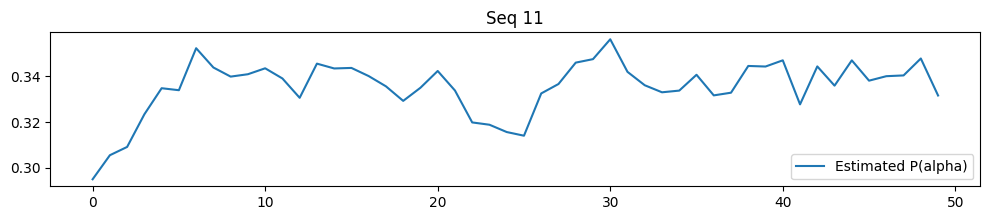


Sequence 12, length 91:
Posterior mean P(alpha): [0.28  0.289 0.293 0.313 0.321 0.324 0.337 0.342 0.332 0.329 0.342 0.355
 0.347 0.363 0.354 0.37  0.369 0.362 0.362 0.354 0.358 0.349 0.341 0.346
 0.332 0.328 0.336 0.332 0.341 0.341 0.352 0.342 0.335 0.327 0.333 0.357
 0.347 0.343 0.347 0.344 0.344 0.334 0.326 0.314 0.315 0.309 0.314 0.314
 0.314 0.293]


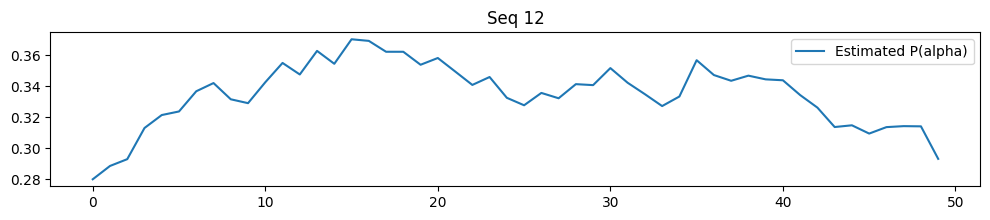


Sequence 13, length 122:
Posterior mean P(alpha): [0.312 0.312 0.313 0.328 0.33  0.321 0.33  0.315 0.308 0.311 0.315 0.323
 0.313 0.338 0.329 0.339 0.337 0.334 0.331 0.329 0.329 0.323 0.325 0.329
 0.315 0.326 0.331 0.331 0.336 0.338 0.354 0.348 0.346 0.352 0.355 0.377
 0.367 0.362 0.364 0.366 0.354 0.337 0.349 0.332 0.32  0.305 0.309 0.302
 0.311 0.29 ]


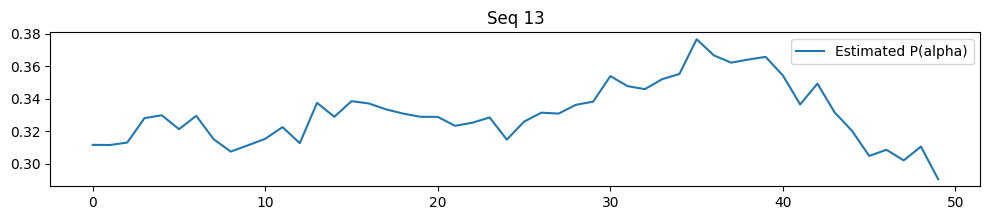


Sequence 14, length 137:
Posterior mean P(alpha): [0.362 0.377 0.384 0.416 0.409 0.388 0.399 0.352 0.346 0.328 0.32  0.318
 0.311 0.325 0.329 0.324 0.318 0.315 0.312 0.316 0.322 0.322 0.326 0.332
 0.331 0.329 0.343 0.344 0.357 0.358 0.372 0.376 0.375 0.372 0.371 0.381
 0.383 0.38  0.381 0.387 0.388 0.385 0.388 0.375 0.374 0.369 0.367 0.367
 0.373 0.343]


KeyboardInterrupt: 

In [5]:
# --- Visualization ---
for i, (seq, L) in enumerate(zip(valid_seqs, lengths)):
    marg = posterior_means[i, :L]
    print(f"\nSequence {i}, length {L}:")
    print("Posterior mean P(alpha):", np.round(marg, 3))

    plt.figure(figsize=(12, 2))
    plt.plot(marg, label="Estimated P(alpha)")

    if labels:
        true = [1 if c == 'A' else 0 for c in labels[i][:L]]
        plt.plot(true, label="True alpha=1 / other=0", color='gray', alpha=0.6)

    plt.legend()
    plt.title(f"Seq {i}")
    plt.show()

It works up to here!!!

In [13]:
all_posteriors = []

for i in range(len(posterior_means)):
    L = posterior_means.shape[1] if isinstance(lengths, int) else lengths[i]
    all_posteriors.append(posterior_means[i, :L])

In [14]:
print("posterior_means shape:", posterior_means.shape)
print("len(lengths):", len(lengths))
print("len(valid_seqs):", len(valid_seqs))

posterior_means shape: (22600, 50)
len(lengths): 28902
len(valid_seqs): 28902
